## LSTM模型

In [1]:
import torch
import torch.nn as nn


class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.9):
        """
        params:
        input_dim          : 输入数据的维度
        hidden_layer_sizes : LSTM 隐藏层的维度列表
        output_dim         : 输出维度
        dropout_rate       : 随机丢弃神经元的概率
        """
        super().__init__()

        # LSTM 参数
        self.num_layers = len(hidden_layer_sizes)  # LSTM 层数
        self.lstm_layers = nn.ModuleList()  # 用于保存 LSTM 层的列表

        # 定义第一层 LSTM
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_layer_sizes[0], batch_first=True, bidirectional=True))

        # 定义后续的 LSTM 层
        for i in range(1, self.num_layers):
            self.lstm_layers.append(
                nn.LSTM(hidden_layer_sizes[i - 1] * 2, hidden_layer_sizes[i], batch_first=True, bidirectional=True)
            )

        # 线性层
        self.linear = nn.Linear(hidden_layer_sizes[-1] * 2, output_dim)

        # LayerNorm 用于归一化
        self.norm = nn.LayerNorm(hidden_layer_sizes[-1] * 2)

        # Dropout 层
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        seq_length = input_seq.size(1)

        # 送入 LSTM 层
        lstm_out = input_seq
        for lstm in self.lstm_layers:
            lstm_out, _ = lstm(lstm_out)  # LSTM 的输出维度为 [batch_size, seq_length, hidden_dim * 2]

        # 对 LSTM 的输出进行归一化
        lstm_out = self.norm(lstm_out)

        # 添加 Dropout
        lstm_out = self.dropout(lstm_out)

        # 使用最后一个时间步的输出进行预测
        predict = self.linear(lstm_out[:, -1, :])  # 取最后一个时间步的输出

        return predict

## Transformer模型

In [2]:
# 定义 Transformer 模型
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, output_dim, dropout_rate=0.48):
        """
        params:
        input_dim          : 输入数据的维度
        hidden_dim         : 注意力维度
        num_layers         : Transformer编码器层数
        num_heads          : 多头注意力头数
        output_dim         : 输出维度
        dropout_rate        : 随机丢弃神经元的概率
        """
        super().__init__()
         # 上采样操作
        self.unsampling = nn.Conv1d(input_dim, 32, 1)

        # 参数
        self.output_dim = output_dim

        # Transformer编码器
        self.hidden_dim = hidden_dim
        # Time Transformer layers
        self.transformer = TransformerEncoder(
            TransformerEncoderLayer(32, num_heads, hidden_dim, dropout=dropout_rate, batch_first=True),
            num_layers
        )

        # 序列平局池化
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # 定义线性层
        self.linear  = nn.Linear(32, output_dim)


    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        # 预处理  先进行上采样
        unsampling = self.unsampling(input_seq.permute(0,2,1))
        # Time-Transformer 处理
        # 在PyTorch中，transformer模型的性能与batch_first参数的设置相关。
        # 当batch_first为True时，输入的形状应为(batch, sequence, feature)，这种设置在某些情况下可以提高推理性能。
        transformer_output = self.transformer(unsampling.permute(0,2,1))  #  torch.Size([1, 1, 32])
        # 序列平均池化操作
        output_avgpool = self.avgpool(transformer_output.transpose(1, 2))  #  torch.Size([1, 32, 1])
        output_avgpool = output_avgpool.reshape(batch_size, -1)  #  torch.Size([1, 32])
        predict = self.linear(output_avgpool)
        return predict

## 数据加载

In [3]:
import warnings
warnings.filterwarnings("ignore")

import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import torch
import torch.nn as nn
import time
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

# 数据加载和预处理
def dataloader(batch_size, workers=0):
    """
    加载和预处理数据集
    """
    # 加载数据集
    train_X = load('dataset/train_X')
    train_Y = load('dataset/train_Y')
    val_X = load('dataset/val_X')
    val_Y = load('dataset/val_Y')
    test_X = load('dataset/test_X')
    test_Y = load('dataset/test_Y')

    # 数据归一化
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()

    # 确保数据是三维的
    assert len(train_X.shape) == 3, "Train set must be 3D"
    assert len(val_X.shape) == 3, "Validation set must be 3D"
    assert len(test_X.shape) == 3, "Test set must be 3D"

    # 将三维数据转换为二维数据进行归一化
    train_set_2d = train_X.reshape(-1, train_X.shape[-1])
    val_set_2d = val_X.reshape(-1, val_X.shape[-1])
    test_set_2d = test_X.reshape(-1, test_X.shape[-1])

    # 应用 StandardScaler
    train_set_2d = scaler.fit_transform(train_set_2d)
    val_set_2d = scaler.transform(val_set_2d)
    test_set_2d = scaler.transform(test_set_2d)

    # 将二维数据转换回三维
    train_X = train_set_2d.reshape(train_X.shape)
    val_X = val_set_2d.reshape(val_X.shape)
    test_X = test_set_2d.reshape(test_X.shape)

    # 创建 DataLoader
    train_loader = Data.DataLoader(
        dataset=Data.TensorDataset(
            torch.as_tensor(train_X, dtype=torch.float32),
            torch.as_tensor(train_Y, dtype=torch.float32)
        ),
        batch_size=batch_size,
        num_workers=workers,
        drop_last=True
    )
    val_loader = Data.DataLoader(
        dataset=Data.TensorDataset(
            torch.as_tensor(val_X, dtype=torch.float32),
            torch.as_tensor(val_Y, dtype=torch.float32)
        ),
        batch_size=batch_size,
        num_workers=workers,
        drop_last=True
    )
    test_loader = Data.DataLoader(
        dataset=Data.TensorDataset(
            torch.as_tensor(test_X, dtype=torch.float32),
            torch.as_tensor(test_Y, dtype=torch.float32)
        ),
        batch_size=batch_size,
        num_workers=workers,
        drop_last=True
    )

    return train_loader, val_loader, test_loader

# 加载数据
batch_size = 32
train_loader, val_loader, test_loader = dataloader(batch_size)

## 模型训练函数

In [4]:
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，确保实验结果可重复
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义模型训练函数
def model_train(epochs, model, optimizer, loss_function, train_loader, val_loader, device, scheduler=None, model_name="Model"):
    """
    模型训练函数
    """
    model = model.to(device)  # 将模型移动到指定设备

    # 初始化最低 MSE 和最佳模型
    minimum_mse = float('inf')
    best_model = model

    # 记录训练和验证损失
    train_mse = []
    val_mse = []

    # 训练开始时间
    start_time = time.time()

    for epoch in range(epochs):
        # 训练模式
        model.train()
        train_mse_loss = []

        # 训练循环
        for seq, labels in train_loader:
            seq, labels = seq.to(device), labels.to(device)
            optimizer.zero_grad()  # 清空梯度
            y_pred = model(seq)  # 前向传播
            loss = loss_function(y_pred, labels)  # 计算损失
            train_mse_loss.append(loss.item())
            loss.backward()  # 反向传播
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 梯度裁剪
            optimizer.step()  # 更新参数

        # 计算平均训练损失
        train_av_mseloss = np.mean(train_mse_loss)
        train_mse.append(train_av_mseloss)

        print(f'Epoch: {epoch + 1:2} Train MSE Loss: {train_av_mseloss:10.8f}')

        # 验证模式
        model.eval()
        val_mse_loss = []

        with torch.no_grad():
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                pred = model(data)
                val_loss = loss_function(pred, label)
                val_mse_loss.append(val_loss.item())

        # 计算平均验证损失
        val_av_mseloss = np.mean(val_mse_loss)
        val_mse.append(val_av_mseloss)

        print(f'Epoch: {epoch + 1:2} Validation MSE Loss: {val_av_mseloss:10.8f}')

        # 更新最佳模型
        if val_av_mseloss < minimum_mse:
            minimum_mse = val_av_mseloss
            best_model = model
            print('Best model saved')

        # 学习率调度
        if scheduler is not None:
            scheduler.step()

    # 保存最佳模型
    torch.save(best_model, f'model/best_model_{model_name}.pt')
    print(f'\nTraining Duration: {time.time() - start_time:.0f} seconds')

    # 绘制损失曲线
    plt.figure(figsize=(12, 6), dpi=100)
    plt.rcParams.update({'font.family': 'serif', 'font.size': 12})
    plt.style.use('seaborn-v0_8-whitegrid')

    # 颜色方案
    train_color = '#1f77b4'  # 蓝色
    val_color = '#ff7f0e'    # 橙色

    plt.plot(range(epochs), train_mse,
             color=train_color,
             linewidth=1.5,
             linestyle='-',
             alpha=0.8,
             label='Train MSE Loss')
    plt.plot(range(epochs), val_mse,
             color=val_color,
             linewidth=1.5,
             linestyle='-',
             alpha=0.8,
             label='Validation MSE Loss')

    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print(f'Minimum Validation MSE: {minimum_mse}')

    return minimum_mse

## LSTM模型训练

Epoch:  1 Train MSE Loss: 4.69039721
Epoch:  1 Validation MSE Loss: 0.80396462
Best model saved
Epoch:  2 Train MSE Loss: 4.35350301
Epoch:  2 Validation MSE Loss: 0.70144734
Best model saved
Epoch:  3 Train MSE Loss: 4.78075609
Epoch:  3 Validation MSE Loss: 0.60768260
Best model saved
Epoch:  4 Train MSE Loss: 4.02706723
Epoch:  4 Validation MSE Loss: 0.55417909
Best model saved
Epoch:  5 Train MSE Loss: 3.36153212
Epoch:  5 Validation MSE Loss: 0.49426587
Best model saved
Epoch:  6 Train MSE Loss: 3.90513878
Epoch:  6 Validation MSE Loss: 0.44839106
Best model saved
Epoch:  7 Train MSE Loss: 3.22659779
Epoch:  7 Validation MSE Loss: 0.39689012
Best model saved
Epoch:  8 Train MSE Loss: 3.07432539
Epoch:  8 Validation MSE Loss: 0.35307110
Best model saved
Epoch:  9 Train MSE Loss: 2.77404709
Epoch:  9 Validation MSE Loss: 0.33448733
Best model saved
Epoch: 10 Train MSE Loss: 3.35540962
Epoch: 10 Validation MSE Loss: 0.29550162
Best model saved
Epoch: 11 Train MSE Loss: 2.74425759
Epo

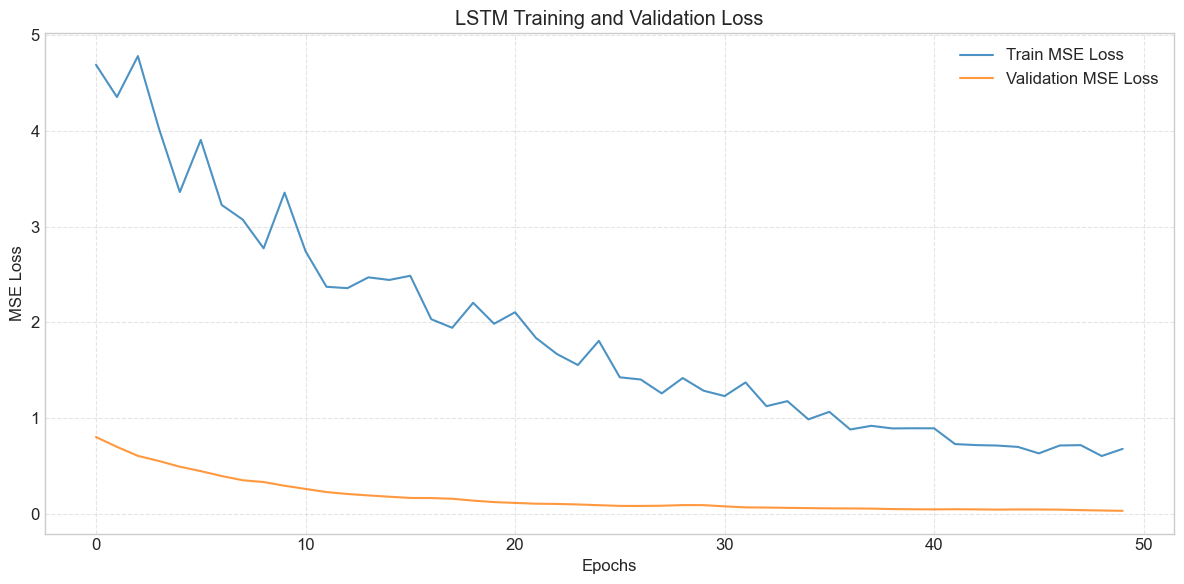

Minimum Validation MSE: 0.033663764130324125


In [5]:
# 定义 LSTM 模型参数
lstm_input_dim = 1    # 输入维度
lstm_hidden_layer_sizes = [32, 64]  # LSTM 层结构
lstm_output_dim = 1   # 输出维度

# 初始化 LSTM 模型
lstm_model = LSTMModel(
    input_dim=lstm_input_dim,
    hidden_layer_sizes=lstm_hidden_layer_sizes,
    output_dim=lstm_output_dim
)

# 定义 LSTM 损失函数和优化器
loss_function = nn.MSELoss()  # 使用均方误差损失
lstm_learn_rate = 0.0001  # 学习率
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lstm_learn_rate, betas=(0.9, 0.999))  # Adam 优化器

# 学习率调度器
from torch.optim.lr_scheduler import StepLR
lstm_scheduler = StepLR(lstm_optimizer, step_size=10, gamma=0.9)

# 训练 LSTM 模型
lstm_epochs = 50
lstm_min_mse = model_train(lstm_epochs, lstm_model, lstm_optimizer, loss_function, train_loader, val_loader, device, lstm_scheduler, model_name="LSTM")

## Transformer模型训练

Epoch:  1 Train MSE Loss: 1.35585666
Epoch:  1 Validation MSE Loss: 0.72940585
Best model saved
Epoch:  2 Train MSE Loss: 1.21435902
Epoch:  2 Validation MSE Loss: 0.63176883
Best model saved
Epoch:  3 Train MSE Loss: 1.14663250
Epoch:  3 Validation MSE Loss: 0.54335530
Best model saved
Epoch:  4 Train MSE Loss: 1.07981552
Epoch:  4 Validation MSE Loss: 0.46585297
Best model saved
Epoch:  5 Train MSE Loss: 0.84685394
Epoch:  5 Validation MSE Loss: 0.39484600
Best model saved
Epoch:  6 Train MSE Loss: 0.80663417
Epoch:  6 Validation MSE Loss: 0.32929562
Best model saved
Epoch:  7 Train MSE Loss: 0.71325690
Epoch:  7 Validation MSE Loss: 0.27084112
Best model saved
Epoch:  8 Train MSE Loss: 0.69006089
Epoch:  8 Validation MSE Loss: 0.22109231
Best model saved
Epoch:  9 Train MSE Loss: 0.62000747
Epoch:  9 Validation MSE Loss: 0.17800937
Best model saved
Epoch: 10 Train MSE Loss: 0.53271344
Epoch: 10 Validation MSE Loss: 0.14026187
Best model saved
Epoch: 11 Train MSE Loss: 0.46945966
Epo

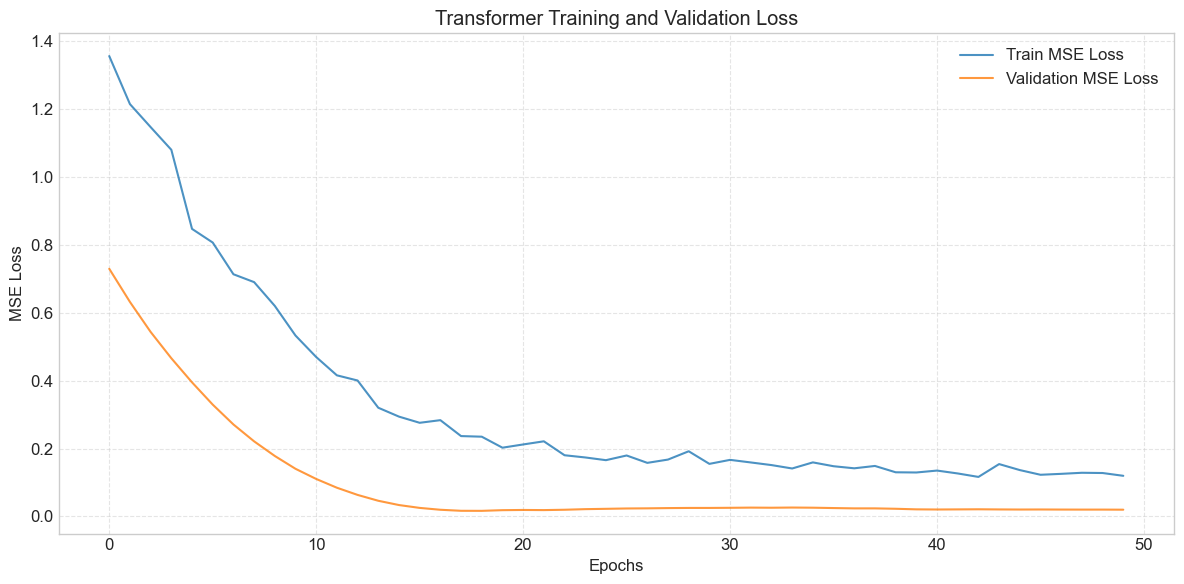

Minimum Validation MSE: 0.01639610966667533


In [6]:
# 定义 Transformer 模型参数
transformer_input_dim = 1    # 输入维度
transformer_hidden_dim = 64  # Transformer 的隐藏维度
transformer_num_layers = 1   # Transformer 编码器层数
transformer_num_heads = 1    # 多头注意力头数（确保 32 能被 num_heads 整除）
transformer_output_dim = 1   # 输出维度

# 初始化 Transformer 模型
transformer_model = TransformerModel(
    input_dim=transformer_input_dim,
    hidden_dim=transformer_hidden_dim,
    num_layers=transformer_num_layers,
    num_heads=transformer_num_heads,
    output_dim=transformer_output_dim
)

# 定义 Transformer 损失函数和优化器
transformer_loss_function = nn.MSELoss()  # 使用均方误差损失
transformer_learn_rate = 0.0001  # 学习率
transformer_optimizer = torch.optim.Adam(transformer_model.parameters(), lr=transformer_learn_rate, betas=(0.9, 0.999))  # Adam 优化器

# 学习率调度器
transformer_scheduler = StepLR(transformer_optimizer, step_size=10, gamma=0.9)

# 训练 Transformer 模型
transformer_epochs = 50
transformer_min_mse = model_train(transformer_epochs, transformer_model, transformer_optimizer, transformer_loss_function, train_loader, val_loader, device, transformer_scheduler, model_name="Transformer")

## 模型性能比较

In [7]:
# 比较两个模型的性能
print(f"\nLSTM Minimum Validation MSE: {lstm_min_mse}")
print(f"Transformer Minimum Validation MSE: {transformer_min_mse}")


LSTM Minimum Validation MSE: 0.033663764130324125
Transformer Minimum Validation MSE: 0.01639610966667533


## 可视化预测结果

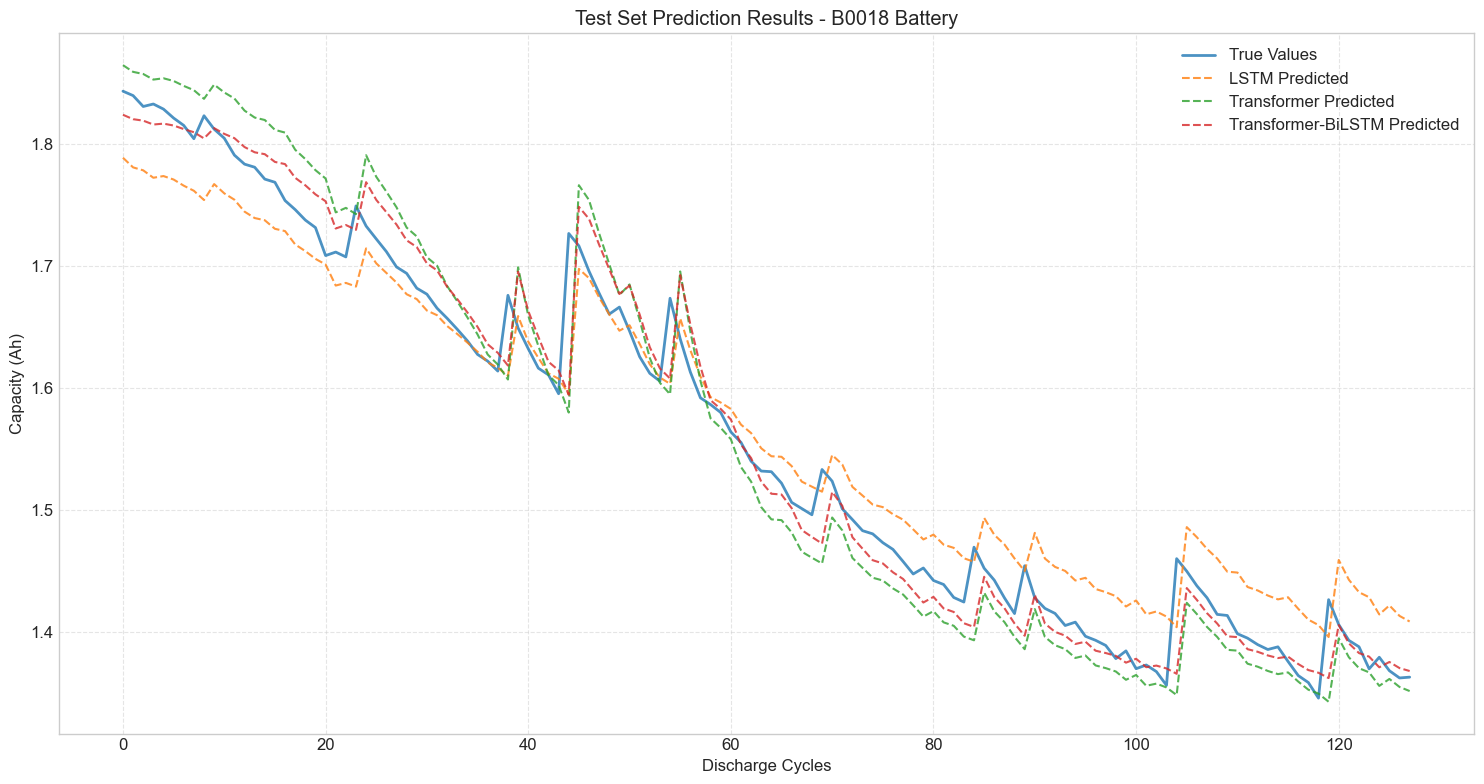

In [8]:
import torch
from joblib import load
import torch.utils.data as Data
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 加载模型和数据
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 假设已经加载了三个模型
lstm_model = torch.load('model/best_model_LSTM.pt')
transformer_model = torch.load('model/best_model_Transformer.pt')
transformer_bilstm_model = torch.load('model/best_model_TransformerBiLSTM.pt')

# 将模型移动到指定设备
lstm_model = lstm_model.to(device)
transformer_model = transformer_model.to(device)
transformer_bilstm_model = transformer_bilstm_model.to(device)

# 预测函数
def predict(model, data_loader, device):
    true_values = []
    predicted_values = []
    with torch.no_grad():
        model.eval()
        for data, label in data_loader:
            true_values += label.tolist()
            data, label = data.to(device), label.to(device)
            pred = model(data)
            predicted_values += pred.tolist()
    return true_values, predicted_values

# 反归一化处理
def inverse_transform(scaler, data):
    return scaler.inverse_transform(data)

# 可视化结果（单图，展示三个模型）
def plot_comparison_results(true_values, lstm_pred, transformer_pred, transformer_bilstm_pred, title):
    plt.figure(figsize=(15, 8), dpi=100)
    plt.rcParams.update({'font.family': 'serif', 'font.size': 12})
    plt.style.use('seaborn-v0_8-whitegrid')

    # 颜色方案
    true_color = '#1f77b4'  # 蓝色
    lstm_color = '#ff7f0e'  # 橙色
    transformer_color = '#2ca02c'  # 绿色
    transformer_bilstm_color = '#d62728'  # 红色

    # 绘制真实值
    plt.plot(true_values, label='True Values', color=true_color, linewidth=2.0, alpha=0.8)

    # 绘制预测值
    plt.plot(lstm_pred, label='LSTM Predicted', color=lstm_color, linewidth=1.5, linestyle='--', alpha=0.8)
    plt.plot(transformer_pred, label='Transformer Predicted', color=transformer_color, linewidth=1.5, linestyle='--',
             alpha=0.8)
    plt.plot(transformer_bilstm_pred, label='Transformer-BiLSTM Predicted', color=transformer_bilstm_color,
             linewidth=1.5, linestyle='--', alpha=0.8)

    plt.title(title)
    plt.xlabel('Discharge Cycles')
    plt.ylabel('Capacity (Ah)')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# 加载归一化模型
scaler = load('dataset/scaler_data')

# 预测测试集
test_true, lstm_pred = predict(lstm_model, test_loader, device)
_, transformer_pred = predict(transformer_model, test_loader, device)
_, transformer_bilstm_pred = predict(transformer_bilstm_model, test_loader, device)

# 反归一化处理
test_true = inverse_transform(scaler, np.array(test_true).reshape(-1, 1))
lstm_pred = inverse_transform(scaler, np.array(lstm_pred).reshape(-1, 1))
transformer_pred = inverse_transform(scaler, np.array(transformer_pred).reshape(-1, 1))
transformer_bilstm_pred = inverse_transform(scaler, np.array(transformer_bilstm_pred).reshape(-1, 1))

# 可视化测试集结果（三个模型的比较）
plot_comparison_results(test_true, lstm_pred, transformer_pred, transformer_bilstm_pred,
                        'Test Set Prediction Results - B0018 Battery')

## 可视化误差

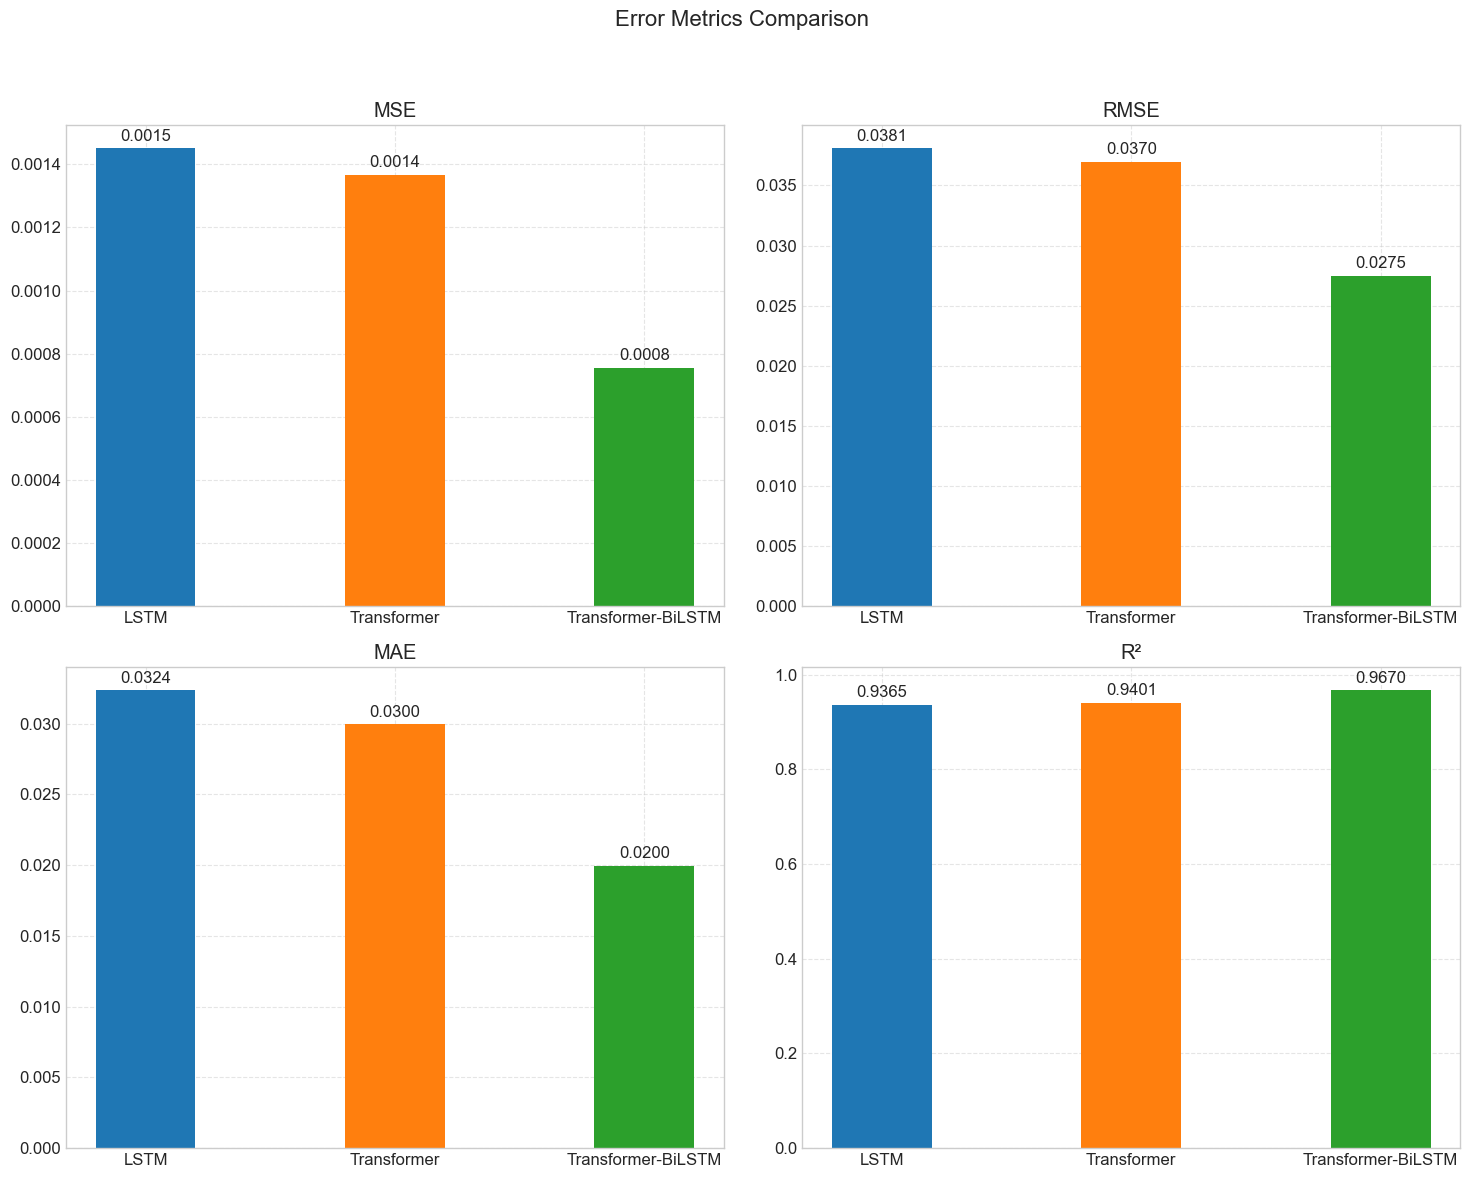

LSTM R^2 Score: 0.9364735049053564
Transformer R^2 Score: 0.9401227835154686
Transformer-BiLSTM R^2 Score: 0.9669523405326
----------------------------------------------------------------------
LSTM Mean Squared Error (MSE):  0.0014506299774375542
LSTM Root Mean Squared Error (RMSE):  0.03808713664004626
LSTM Mean Absolute Error (MAE):  0.03236748504863341
----------------------------------------------------------------------
Transformer Mean Squared Error (MSE):  0.001367298558948881
Transformer Root Mean Squared Error (RMSE):  0.03697700040496634
Transformer Mean Absolute Error (MAE):  0.029963512363437146
----------------------------------------------------------------------
Transformer-BiLSTM Mean Squared Error (MSE):  0.0007546445846907824
Transformer-BiLSTM Root Mean Squared Error (RMSE):  0.02747079512301714
Transformer-BiLSTM Mean Absolute Error (MAE):  0.019969219178996925


In [9]:
# 可视化误差指标（四个子图）
def plot_error_metrics_subplots(metrics, title):
    metrics_names = ['MSE', 'RMSE', 'MAE', 'R²']
    models = ['LSTM', 'Transformer', 'Transformer-BiLSTM']

    fig, axes = plt.subplots(2, 2, figsize=(15, 12), dpi=100)
    fig.suptitle(title, fontsize=16)

    for i, metric_name in enumerate(metrics_names):
        ax = axes[i // 2, i % 2]
        values = [metrics[model][metric_name] for model in models]
        # 设置柱状图的宽度
        bar_width = 0.4
        x = np.arange(len(models))
        bars = ax.bar(x, values, width=bar_width, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        ax.set_xticks(x)
        ax.set_xticklabels(models)
        ax.set_title(metric_name)
        ax.grid(True, linestyle='--', alpha=0.5)
        # 添加数值标签
        max_value = max(values)
        offset = max_value * 0.01  # 根据最大值动态调整偏移量
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height + offset,
                    f'{height:.4f}', ha='center', va='bottom')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# 计算误差指标
def calculate_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}


# 计算误差指标
lstm_metrics = calculate_metrics(test_true, lstm_pred)
transformer_metrics = calculate_metrics(test_true, transformer_pred)
transformer_bilstm_metrics = calculate_metrics(test_true, transformer_bilstm_pred)

# 将误差指标存储在一个字典中
metrics = {
    'LSTM': lstm_metrics,
    'Transformer': transformer_metrics,
    'Transformer-BiLSTM': transformer_bilstm_metrics
}

# 可视化误差指标（四个子图）
plot_error_metrics_subplots(metrics, 'Error Metrics Comparison')

# 打印误差指标
print('LSTM R^2 Score:', lstm_metrics['R²'])
print('Transformer R^2 Score:', transformer_metrics['R²'])
print('Transformer-BiLSTM R^2 Score:', transformer_bilstm_metrics['R²'])
print('-' * 70)
print('LSTM Mean Squared Error (MSE): ', lstm_metrics['MSE'])
print('LSTM Root Mean Squared Error (RMSE): ', lstm_metrics['RMSE'])
print('LSTM Mean Absolute Error (MAE): ', lstm_metrics['MAE'])
print('-' * 70)
print('Transformer Mean Squared Error (MSE): ', transformer_metrics['MSE'])
print('Transformer Root Mean Squared Error (RMSE): ', transformer_metrics['RMSE'])
print('Transformer Mean Absolute Error (MAE): ', transformer_metrics['MAE'])
print('-' * 70)
print('Transformer-BiLSTM Mean Squared Error (MSE): ', transformer_bilstm_metrics['MSE'])
print('Transformer-BiLSTM Root Mean Squared Error (RMSE): ', transformer_bilstm_metrics['RMSE'])
print('Transformer-BiLSTM Mean Absolute Error (MAE): ', transformer_bilstm_metrics['MAE'])